# Euro 2020 (2021) Predictions

<!-- Written report for this analysis can be found [here](../reports/boro_01_market_value.md) -->

## 1. Business Understanding

* Determine Busines Objectives
* Situation Assessment
* Determine Data Mining Goal
* Produce Project Plan

```
# 1. Predict results of every match at Euro 2020
# 2. Make predictions before each round of competition
# 3. Ideally, at each round, use the predictions to simulate remainder of competition
# 4. Check against other predictions and actual results
# 5. Write up process (report/blog)
```

## 2. Data Understanding

* Collect Initial Data
* Describe Data
* Explore Data
* Verify Data Quality

### EURO 2020 fixtures/results
* https://en.wikipedia.org/wiki/UEFA_Euro_2020
* https://www.whoscored.com/Regions/247/Tournaments/124/Seasons/7329/Stages/16297/Show/International-European-Championship-2020
* https://www.uefa.com/uefaeuro-2020/fixtures-results/#/md/33673
* https://fbref.com/en/comps/676/schedule/UEFA-Euro-Scores-and-Fixtures

### Historic results
* https://www.staff.city.ac.uk/r.j.gerrard/football/aifrform.html (1871-2001)
* https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017/data (1872-)
* https://fbref.com/en/comps/676/history/European-Championship-Seasons (2000-)
* https://en.wikipedia.org/wiki/UEFA_Euro_2020_qualifying (qualifying)
* https://fbref.com/en/comps/678/Euro-Qualifying-Stats (qualifying)

### ELO ratings
* https://en.m.wikipedia.org/wiki/World_Football_Elo_Ratings
* https://www.eloratings.net/2021_European_Championship
* http://eloratings.net/2016_European_Championship_start
* https://www.eloratings.net/about

### Historic trends
* https://blog.annabet.com/soccer-goal-probabilities-poisson-vs-actual-distribution/
* https://en.wikipedia.org/wiki/Poisson_distribution

### GDP
* https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)
* https://en.wikipedia.org/wiki/List_of_countries_by_past_and_projected_GDP_(nominal)
* https://www.rug.nl/ggdc/productivity/pwt/

In [5]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import seaborn as sns
sns.set()

import src.utilities as utilities

In [10]:
match = utilities.get_master("nations_matches")
match.info()

2021-05-11 20:25:40,466 - INFO - Building master filepath for nations_matches
2021-05-11 20:25:40,467 - INFO - Fetching C:\Users\adeacon\Documents\GitHub\the-ball-is-round\data\processed\ftb_nations_matches.txt
2021-05-11 20:25:40,468 - INFO - Building master filepath for nations_matches


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     211 non-null    int64  
 1   Round          211 non-null    object 
 2   Wk             168 non-null    float64
 3   Day            211 non-null    object 
 4   Date           211 non-null    object 
 5   Time           211 non-null    object 
 6   Team_1         211 non-null    object 
 7   Score          175 non-null    object 
 8   Team_2         211 non-null    object 
 9   Attendance     175 non-null    float64
 10  Venue          211 non-null    object 
 11  Referee        175 non-null    object 
 12  Match Report   211 non-null    object 
 13  Notes          16 non-null     object 
 14  Year           211 non-null    int64  
 15  Team_abbrev_1  211 non-null    object 
 16  Team_abbrev_2  211 non-null    object 
 17  Goals_1        175 non-null    float64
 18  Goals_2   

In [11]:
match = match[['Round', 'Day', 'Date', 'Time', 'Team_1', 'Team_2',
       'Year', 'Goals_1', 'Goals_2',
       'Goal_diff', 'Venue', 'Venue_country', 'Venue_city', 'Home_1',
       'Home_2']]

match["Goal_total"] = match.Goals_1 + match.Goals_2

match.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Round,211,5,Group stage,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day,211,7,Sun,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,211,110,2016-06-21,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,211,16,20:45 (19:45),52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team_1,211,35,Portugal,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team_2,211,35,Portugal,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,211,NaN,NaN,NaN,2010.98,7.05586,2000,2004,2012,2016,2021
Goals_1,175,NaN,NaN,NaN,1.46857,1.34672,0,0,1,2,6
Goals_2,175,NaN,NaN,NaN,1.11429,1.00491,0,0,1,2,4
Goal_diff,175,NaN,NaN,NaN,0.354286,1.75845,-4,-1,0,1,5


In [12]:
## checks on gaps in venue matching

match.fillna("").groupby(["Year", "Venue", "Venue_city", "Venue_country"]).Date.count()

Year  Venue                               Venue_city         Venue_country
2000  GelreDome                           Arnhem             Netherlands      3
      Jan Breydelstadion                  Bruges             Belgium          4
      Johan Cruyff ArenA                  Amsterdam          Netherlands      5
      Philips Stadion                     Eindhoven          Netherlands      3
      Stade Maurice Dufrasne              Liège              Belgium          3
      Stade Roi Baudouin                  Brussels           Belgium          5
      Stade du Pays de Charleroi          Charleroi          Belgium          3
      Stadion Feijenoord                  Rotterdam          Netherlands      5
2004  EstÃ¡dio Do Algarve                                                     3
      EstÃ¡dio Do DragÃ£o                                                     5
      EstÃ¡dio Dom Afonso Henriques                                           2
      EstÃ¡dio Dr. MagalhÃ£es Pessoa         


Goal_diff



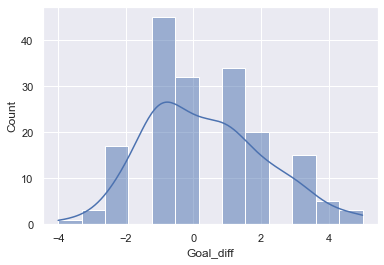

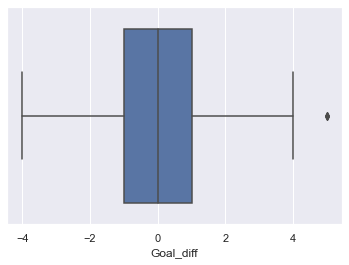


--------------------

Goal_total



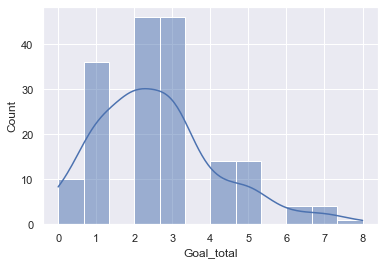

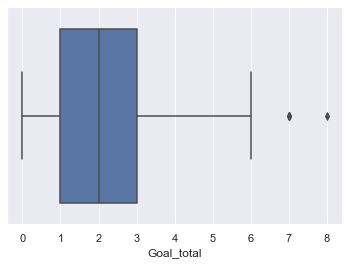


--------------------


In [30]:
def metric_histograms(df, metrics):
#     df = df_in.dropna(subset=[metric]).fillna("NULL")
    for metric in metrics:
        print("\n{0}\n".format(metric))
#         df[metric].hist()
        sns.histplot(data=df, x=metric, kde=True)
        plt.show()
        sns.boxplot(x=df[metric])
        plt.show()
        print("\n--------------------")

metric_histograms(match, ["Goal_diff", "Goal_total"])


Round

Group stage       132
Quarter-finals     20
Semi-finals        10
Round of 16         8
Final               5
Name: Round, dtype: int64


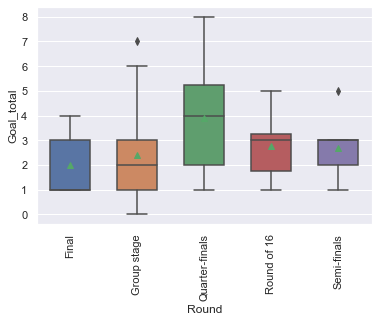


--------------------

Day

Sun    36
Sat    30
Wed    27
Mon    23
Tue    22
Thu    19
Fri    18
Name: Day, dtype: int64


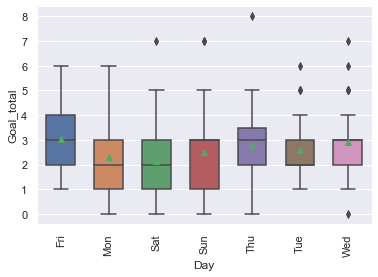


--------------------

Time

20:45 (19:45)    52
18:00 (17:00)    38
21:00 (20:00)    27
19:45            23
21:45 (19:45)    11
15:00 (14:00)     9
17:00             8
19:00 (17:00)     4
14:30 (13:30)     1
20:00 (19:00)     1
22:00 (20:00)     1
Name: Time, dtype: int64


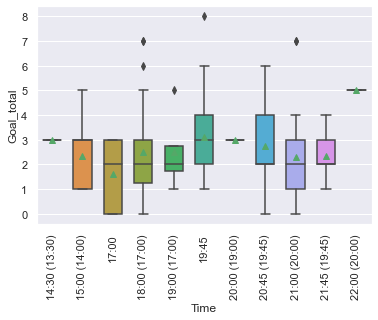


--------------------

Year

2016    51
2012    31
2008    31
2004    31
2000    31
Name: Year, dtype: int64


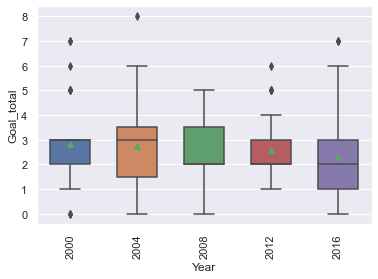


--------------------

Venue_country

NULL           47
France         45
Netherlands    16
Ukraine        16
Belgium        15
Austria        13
Switzerland    12
Poland         11
Name: Venue_country, dtype: int64


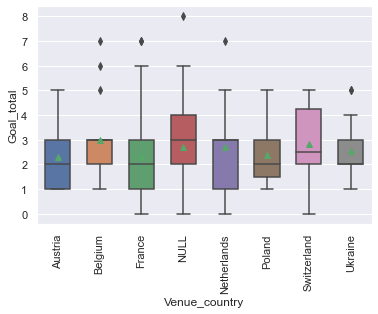


--------------------


In [35]:
def group_boxplots(df_in, cols, metric):
    df = df_in.dropna(subset=[metric]).fillna("NULL")
    for col in cols:
        print("\n{0}\n".format(col))
        print(df[col].value_counts())
        sns.boxplot(x=col, y=metric, data=df.sort_values(by=col), 
                    showmeans=True, width=0.6)
        plt.xticks(rotation=90)

    #     plt.savefig("../reports/figures/club_01_boxplot_{0}.PNG".format(col))
        plt.show()
        print("\n--------------------")
        
col_list = ["Round", "Day", "Time", "Year", "Venue_country"]

group_boxplots(match, col_list, "Goal_total")

In [20]:
summary = utilities.get_master("nations_summaries")
summary.info()

2021-05-11 20:33:53,181 - INFO - Building master filepath for nations_summaries
2021-05-11 20:33:53,181 - INFO - Fetching C:\Users\adeacon\Documents\GitHub\the-ball-is-round\data\processed\ftb_nations_summaries.txt
2021-05-11 20:33:53,181 - INFO - Building master filepath for nations_summaries


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            112 non-null    int64  
 1   Rank Local            112 non-null    int64  
 2   Rank Global           112 non-null    int64  
 3   Team                  112 non-null    object 
 4   Rating                112 non-null    int64  
 5   Average Rank          112 non-null    int64  
 6   Average Rating        112 non-null    int64  
 7   1 Year Change Rank    112 non-null    int64  
 8   1 Year Change Rating  112 non-null    int64  
 9   Matches Total         112 non-null    int64  
 10  Matches Home          112 non-null    int64  
 11  Matches Away          112 non-null    int64  
 12  Matches Neutral       112 non-null    int64  
 13  Matches Wins          112 non-null    int64  
 14  Matches Losses        112 non-null    int64  
 15  Matches Draws         1

In [22]:
summary = summary[['Rank Local', 'Rank Global', 'Team', 'Rating',
       'Average Rank', 'Average Rating', '1 Year Change Rank',
       '1 Year Change Rating', 'Matches Total', 'Matches Home', 'Matches Away',
       'Matches Neutral', 'Matches Wins', 'Matches Losses', 'Matches Draws',
       'Goals For', 'Goals Against', 'Year', 'Country',
       'Data Year', 'GDP (PPP)', 'Population']]

summary["GDP (PPP) Per Capita"] = summary['GDP (PPP)'] / summary['Population']


summary.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank Local,112,NaN,NaN,NaN,10.1964,6.06398,1,5,10,14.25,24
Rank Global,112,NaN,NaN,NaN,18.6964,14.7769,1,8,15,26,74
Team,112,35,Germany,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,112,NaN,NaN,NaN,1856,122.945,1524,1771.25,1853,1948.25,2127
Average Rank,112,NaN,NaN,NaN,22.5268,16.0921,4,11,19,27.25,83
Average Rating,112,NaN,NaN,NaN,1769.49,128.753,1390,1704.75,1785.5,1875.25,1985
1 Year Change Rank,112,NaN,NaN,NaN,1.41071,5.92073,-15,-2,1,4,23
1 Year Change Rating,112,NaN,NaN,NaN,7.26786,42.6667,-92,-24.25,7.5,35.25,127
Matches Total,112,NaN,NaN,NaN,638.009,214.417,63,537.25,659.5,787,1073
Matches Home,112,NaN,NaN,NaN,285.482,98.4145,23,223,295,360,467



Rating



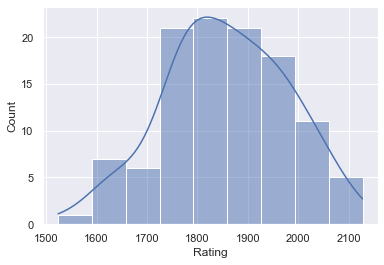

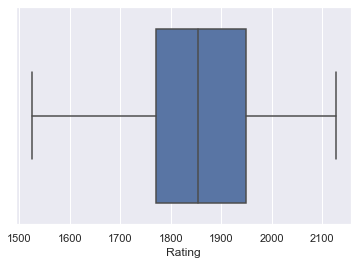


--------------------

Average Rank



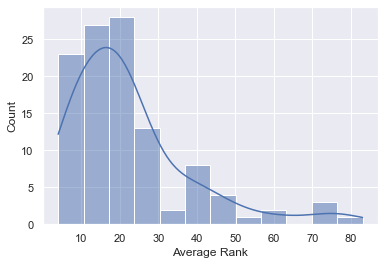

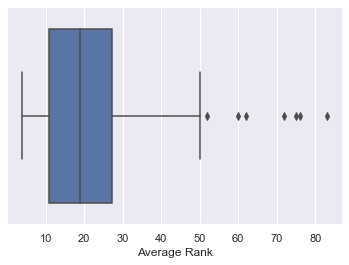


--------------------

Average Rating



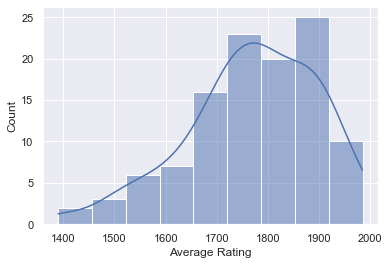

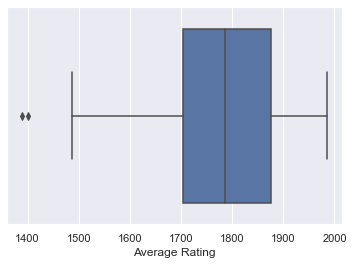


--------------------

1 Year Change Rank



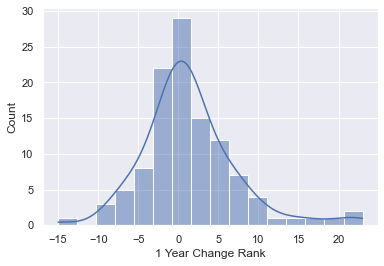

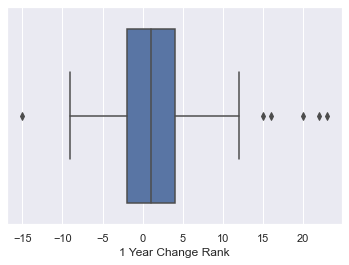


--------------------

1 Year Change Rating



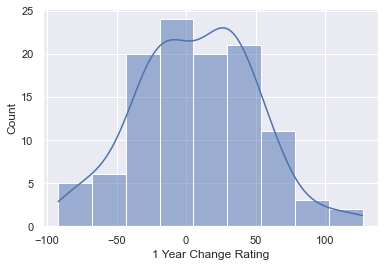

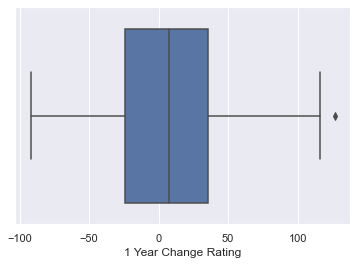


--------------------

Matches Total



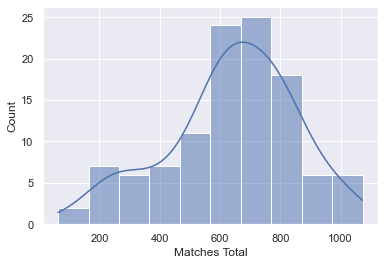

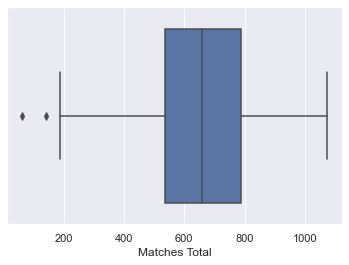


--------------------

Matches Home



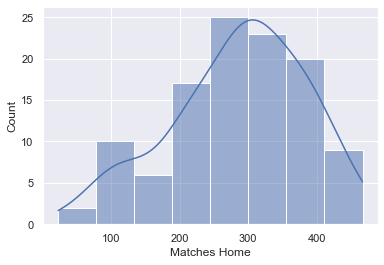

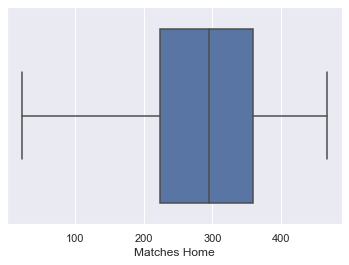


--------------------

Matches Away



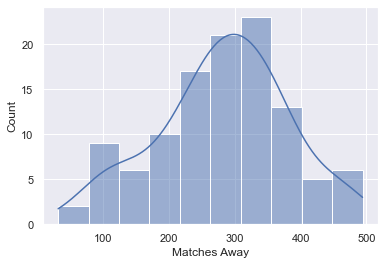

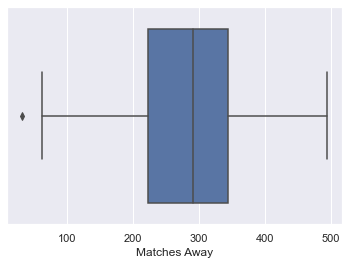


--------------------

Matches Neutral



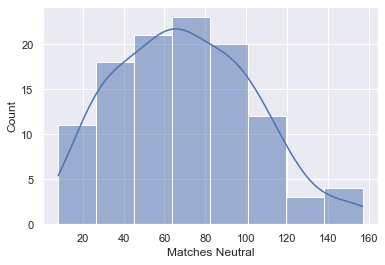

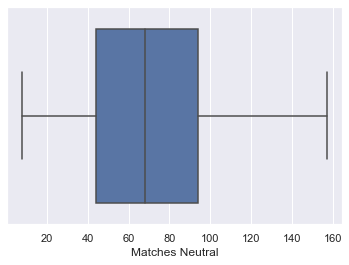


--------------------

Matches Wins



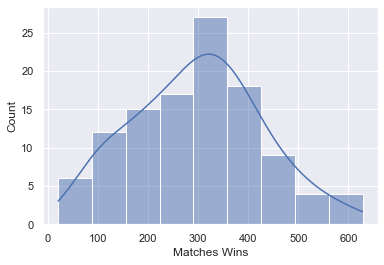

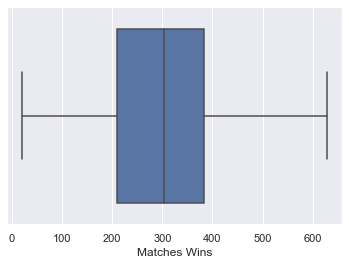


--------------------

Matches Losses



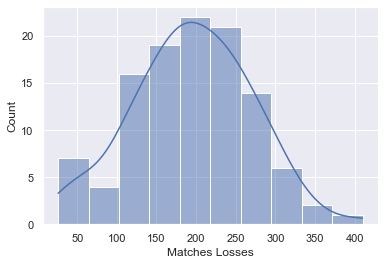

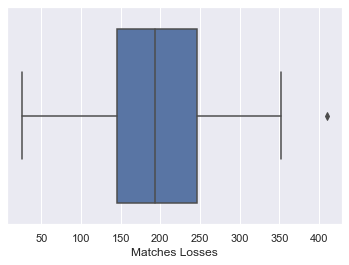


--------------------

Matches Draws



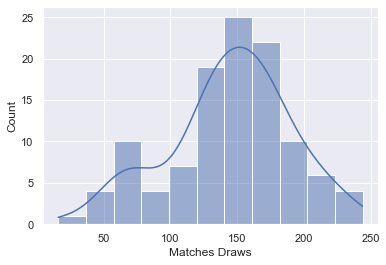

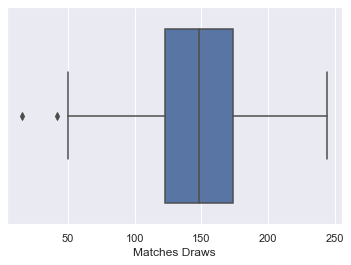


--------------------

Goals For



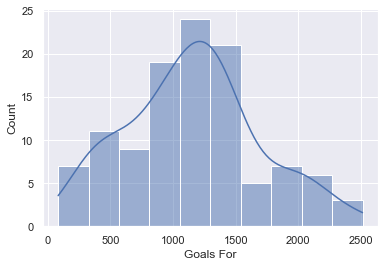

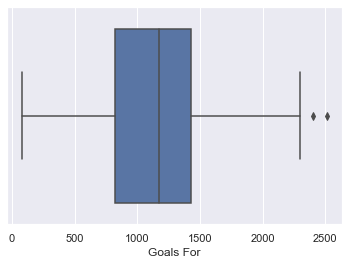


--------------------

Goals Against



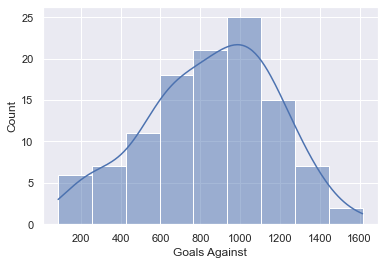

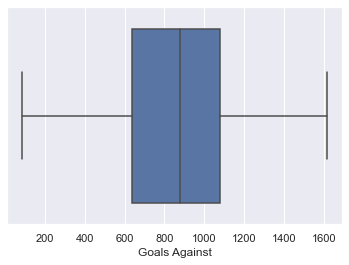


--------------------

GDP (PPP)



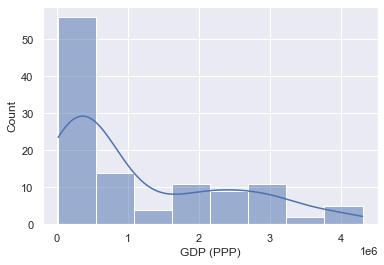

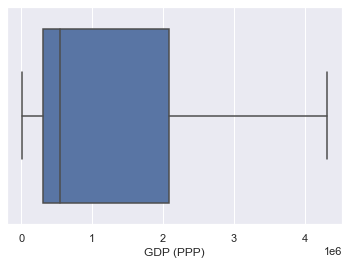


--------------------

Population



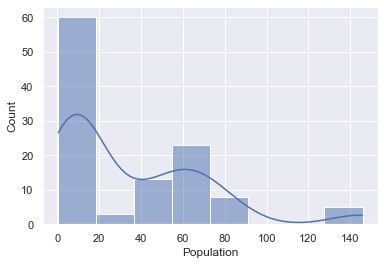

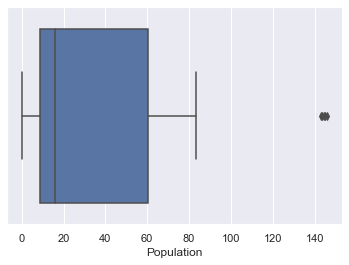


--------------------

GDP (PPP) Per Capita



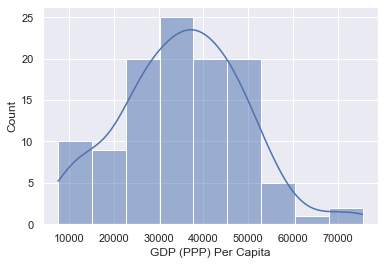

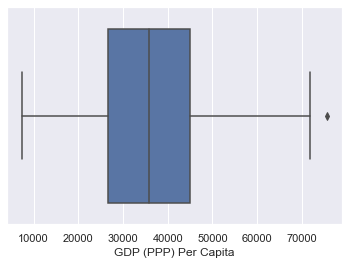


--------------------


In [32]:
metric_histograms(summary, ['Rating', 'Average Rank',
       'Average Rating', '1 Year Change Rank', '1 Year Change Rating',
       'Matches Total', 'Matches Home', 'Matches Away', 'Matches Neutral',
       'Matches Wins', 'Matches Losses', 'Matches Draws', 'Goals For',
       'Goals Against', 'GDP (PPP)',
       'Population', 'GDP (PPP) Per Capita'])

## 3. Data Preperation

* Select Data
* Clean Data
* Construct Data
* Integrate Data
* Format Data

In [37]:
match.head()

,Round,Day,Date,Time,Team_1,Team_2,Year,Goals_1,Goals_2,Goal_diff,Venue,Venue_country,Venue_city,Home_1,Home_2,Goal_total
0,Group stage,Sat,2000-06-10,20:45 (19:45),Belgium,Sweden,2000,2.0,1.0,1.0,Stade Roi Baudouin,Belgium,Brussels,1,0,3.0
1,Group stage,Sun,2000-06-11,14:30 (13:30),Turkey,Italy,2000,1.0,2.0,-1.0,GelreDome,Netherlands,Arnhem,0,0,3.0
2,Group stage,Sun,2000-06-11,18:00 (17:00),France,Denmark,2000,3.0,0.0,3.0,Jan Breydelstadion,Belgium,Bruges,0,0,3.0
3,Group stage,Sun,2000-06-11,20:45 (19:45),Netherlands,Czech Republic,2000,1.0,0.0,1.0,Johan Cruyff ArenA,Netherlands,Amsterdam,1,0,1.0
4,Group stage,Mon,2000-06-12,18:00 (17:00),Germany,Romania,2000,1.0,1.0,0.0,Stade Maurice Dufrasne,Belgium,Liège,0,0,2.0


In [38]:
summary.head()

,Rank Local,Rank Global,Team,Rating,Average Rank,Average Rating,1 Year Change Rank,1 Year Change Rating,Matches Total,Matches Home,...,Matches Losses,Matches Draws,Goals For,Goals Against,Year,Country,Data Year,GDP (PPP),Population,GDP (PPP) Per Capita
0,1,2,France,2063,19,1735,0,25,591,300,...,214,118,1045,1016,2000,France,1999,2.030947e+06,60.535179,33549.863626
1,2,3,Spain,2017,8,1917,1,17,445,210,...,100,115,848,455,2000,Spain,1999,1.112636e+06,40.454470,27503.425456
2,3,4,Netherlands,1963,17,1807,1,-2,584,277,...,184,127,1217,868,2000,Netherlands,1999,6.503119e+05,15.835523,41066.649646
3,4,6,Czech Republic,1945,11,1866,3,21,590,235,...,178,134,1114,789,2000,Czech Republic,1999,2.256548e+05,10.306411,21894.607941
4,5,7,Serbia,1943,18,1786,-1,-3,573,208,...,178,117,1161,852,2000,Serbia,1999,5.650237e+04,7.540401,7493.284135


In [43]:
data = match.merge(summary, left_on=["Team_1", "Year"], right_on=["Team", "Year"], suffixes=["", "_1"])
data = data.merge(summary, left_on=["Team_2", "Year"], right_on=["Team", "Year"], suffixes=["", "_2"])
data["Elo rating diff"] = data["Rating"] - data["Rating_2"]
data["Home advantage"] = data["Home_1"] - data["Home_2"]
# data["Relative experience"] = 
# data["Relative population"] = 
# data["Relative GDP per capita"] = 
data = data[["Goal_diff", "Elo rating diff", "Home advantage"]]
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Goal_diff,145.0,0.310345,1.757987,-4.0,-1.0,0.0,1.0,5.0
Elo rating diff,173.0,4.011561,175.041623,-398.0,-111.0,6.0,137.0,444.0
Home advantage,173.0,0.040462,0.474444,-1.0,0.0,0.0,0.0,1.0


In [40]:
data.columns

Index(['Round', 'Day', 'Date', 'Time', 'Team_1', 'Team_2', 'Year', 'Goals_1',
       'Goals_2', 'Goal_diff', 'Venue', 'Venue_country', 'Venue_city',
       'Home_1', 'Home_2', 'Goal_total', 'Rank Local', 'Rank Global', 'Team',
       'Rating', 'Average Rank', 'Average Rating', '1 Year Change Rank',
       '1 Year Change Rating', 'Matches Total', 'Matches Home', 'Matches Away',
       'Matches Neutral', 'Matches Wins', 'Matches Losses', 'Matches Draws',
       'Goals For', 'Goals Against', 'Country', 'Data Year', 'GDP (PPP)',
       'Population', 'GDP (PPP) Per Capita', 'Rank Local_2', 'Rank Global_2',
       'Team_2', 'Rating_2', 'Average Rank_2', 'Average Rating_2',
       '1 Year Change Rank_2', '1 Year Change Rating_2', 'Matches Total_2',
       'Matches Home_2', 'Matches Away_2', 'Matches Neutral_2',
       'Matches Wins_2', 'Matches Losses_2', 'Matches Draws_2', 'Goals For_2',
       'Goals Against_2', 'Country_2', 'Data Year_2', 'GDP (PPP)_2',
       'Population_2', 'GDP (PPP) Pe

## 4. Modelling

* Select Modelling Technique
* Generate Test Design
* Build Model
* Assess Model

### Updated WC model
* https://github.com/deacona/the-ball-is-round/blob/master/reports/intl_01_world_cup_2018.md
* https://github.com/deacona/the-ball-is-round/blob/master/notebooks/intl_01_world_cup_2018.ipynb

### "Soccernomics"
* goal diff = (0.6666 * home adv) + (0.5 * relative experience) + (0.1 * relative population) + (0.1 * relative gdp/head) + ...
* e.g. England vs Germany at Euro 96
    * Home = England = 1
    * Exp = 84k v 84k = 0
    * Pop = 57 v 81 = -0.4
    * GDP/h = 1627492 / 57 v 2633828 / 81 = -0.1
    * GD = (0.6666 * 1) + (0.5 * 0) + (0.1 * -0.4) + (0.1 * -0.1) = 0.6
* http://www.soccernomics-agency.com/wordpress/wp-content/uploads/2017/10/soccer-convergence-1.pdf

### Dixon-Coles (and other probability models)
* https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling-dixon-coles-and-time-weighting/
* http://www.statsandsnakeoil.com/2018/06/05/modelling-the-world-cup-with-regista/
* http://opisthokonta.net/?cat=48

## 5. Evaluation

* Evaluate Results
* Review Process
* Determine Next Steps

```
# % correct score, goal diff, result, points
# vs historic trends (goals, W/D/L)
```

## 6. Deployment

* Plan Deployment
* Plan Monitoring and Maintenance
* Produce Final Report
* Review Project